In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [39]:
# データを読み込む
data_dir = '../Mining_DATA/Formatted_DATA/'

# csvファイルのリストを取得
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# データを格納するための辞書
data_dict = {}

# 各csvファイルを読み込む
for file in csv_files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    data_dict[file] = df

# AAPL.csvを除外して説明変数を作成
appl_data = data_dict['AAPL.csv']

# 同じ日付で他のCSVのDataカラムを結びつける
merged_data = appl_data[['Date', 'Open']].copy()  # 目的変数

# AAPL.csv以外のCSVファイルのDataカラムを結びつける
for file, df in data_dict.items():
    if file != 'AAPL.csv':
        merged_data = pd.merge(merged_data, df[['Date', 'Open']], on='Date', suffixes=('', f'_{file[:-4]}'))

merged_data.replace(0, np.nan, inplace=True)  # ゼロをNaNに変換
merged_data.ffill(inplace=True)  # 前方向補完
merged_data.bfill(inplace=True)  # 後方向補完

# 説明変数と目的変数に分ける
X = merged_data.drop(columns=['Date', 'Open'])  # 説明変数
y = merged_data['Open']  # 目的変数（AAPL.csvのOpen）

# データをtrainとtestに8:2で分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# データを標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# モデルの作成 (ニューラルネットワーク)
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# モデルの学習
model.fit(X_train_scaled, y_train, epochs=70, batch_size=128, validation_split=0.2)

# testデータで予測を実行
y_pred = model.predict(X_test_scaled)

# 精度評価
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Epoch 1/70
44/44 [==============================] - 2s 16ms/step - loss: 22.8399 - val_loss: 198.3740
Epoch 2/70
44/44 [==============================] - 0s 10ms/step - loss: 1.0176 - val_loss: 423.2151
Epoch 3/70
44/44 [==============================] - 0s 11ms/step - loss: 0.4191 - val_loss: 358.5230
Epoch 4/70
44/44 [==============================] - 0s 11ms/step - loss: 0.4928 - val_loss: 292.9167
Epoch 5/70
44/44 [==============================] - 0s 11ms/step - loss: 0.2664 - val_loss: 178.3162
Epoch 6/70
44/44 [==============================] - 0s 11ms/step - loss: 0.5029 - val_loss: 170.4783
Epoch 7/70
44/44 [==============================] - 0s 11ms/step - loss: 1.6631 - val_loss: 320.7359
Epoch 8/70
44/44 [==============================] - 0s 11ms/step - loss: 1.1289 - val_loss: 201.3410
Epoch 9/70
44/44 [==============================] - 0s 11ms/step - loss: 0.2792 - val_loss: 197.0549
Epoch 10/70
44/44 [==============================] - 0s 11ms/step - loss: 0.1231 - val_los

In [40]:
model.save('NN.h5')

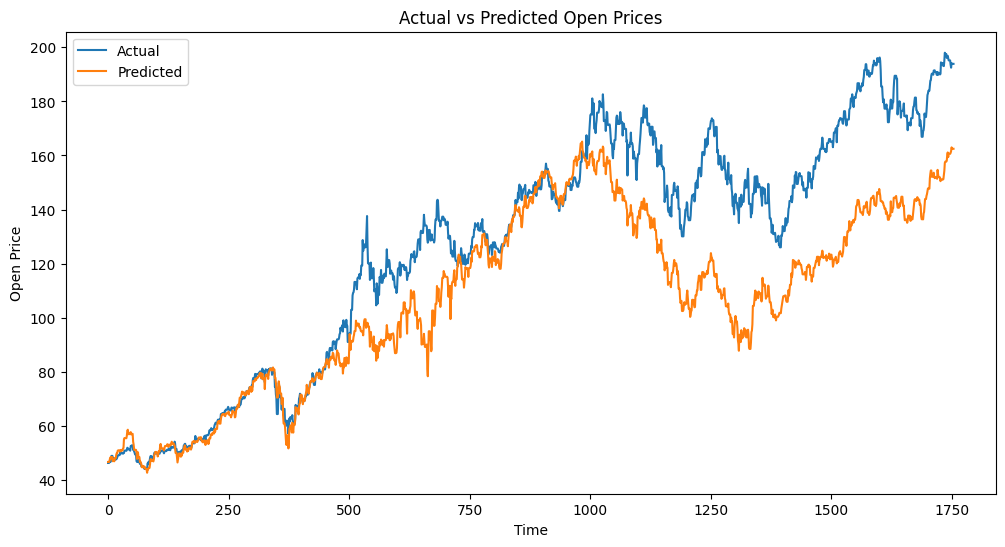

In [41]:
import matplotlib.pyplot as plt

# 予測結果と実際の値をプロット
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.title('Actual vs Predicted Open Prices')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# データをプロットする
plt.figure(figsize=(12, 6))

# 各株のOpen値をプロット
for file, df in data_dict.items():
    plt.plot(df['Date'], df['Open'], label=file[:-4])

# プロットの設定
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Open Prices')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()

# プロットを表示
plt.show()
